In [17]:
#This is an implementation of the first algorithm shown in the paper : clustering with generalized eigen-decomposition.

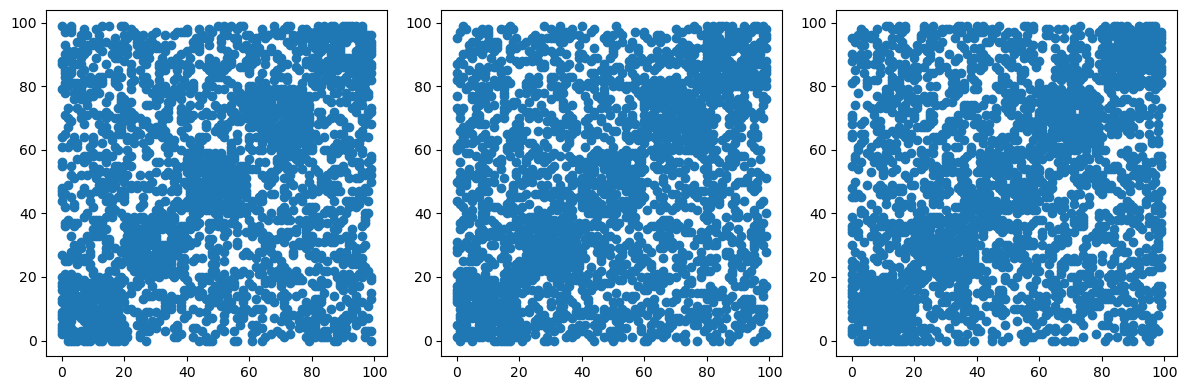

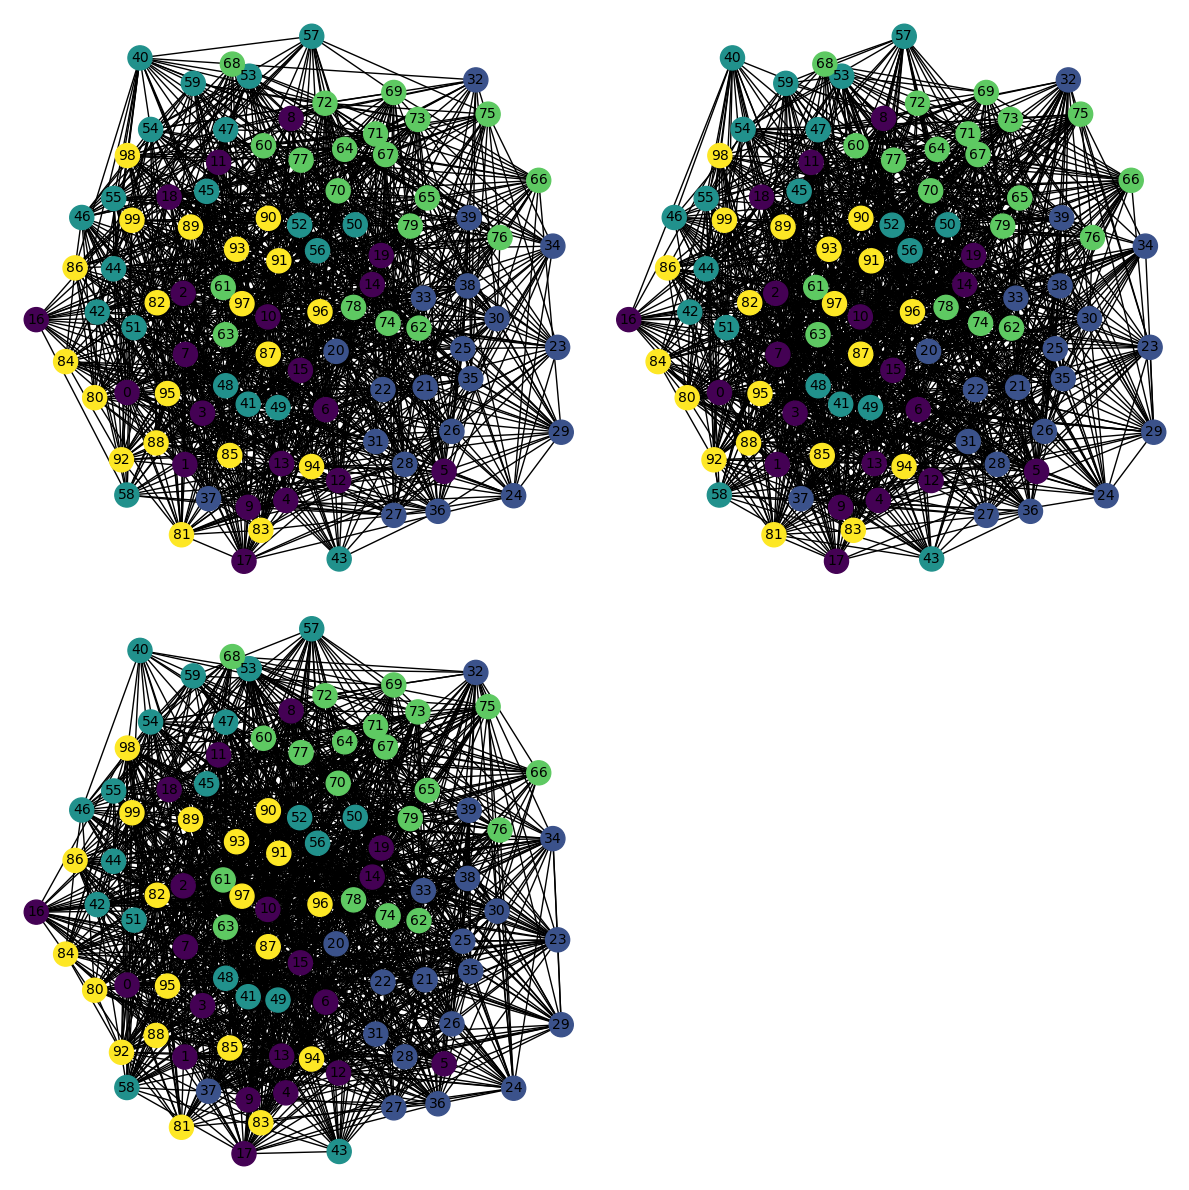

In [18]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")
import utils
%run GraphCreation.ipynb

In [36]:
n = 100
M = 2
k = 5

prob = np.full((k,M),0.7)
prob_prime = np.full((k,k,M),0.3)
clusters_size = k*[20]

matrix,index_cluster = graph_creation_1(n,M,k,clusters_size,prob,prob_prime)

In [20]:
def compute_degree_matrix(M):
  res = np.array([0]*len(M))
  for i in range(len(M)):
    for j in range(len(M)):
      if(M[i][j] != 0):
        res[i]+=1
  return np.diag(res)

In [21]:
def k_means_cluster(U,k):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(U)
  return kmeans.labels_

In [34]:
#alpha and beta have to be choosen according to the dataset we are studying


def spectral_clustering(W,k):


  alpha = 10
  beta = 100
  iter = 0
  iter_max = 500
  stopping_condition = False
  condition = 0.001

  n,_,M = W.shape
  L = np.zeros(np.shape(W))
  delta = np.zeros(np.shape(W))
  for i in range(M):
    W_i = W[: , : ,i]
    D = compute_degree_matrix(W_i)
    L[:, :, i] = np.linalg.inv(D)@(D-W_i)
    eigenvalues,eigenvectors = np.linalg.eig(L[:, :, i])
    delta[: , :, i] = np.diag(eigenvalues)

  eigenvalues,eigenvectors = np.linalg.eig(L[:, :, 0])
  P = eigenvectors
  Q = np.linalg.inv(P)

  while(stopping_condition == False and iter<iter_max):

    print("iter : ",iter)

    def function_to_optimize_P(P_vectorized):
      P = P_vectorized.reshape((n,n))
      res = 0.5*alpha*(np.linalg.norm(P,'fro')**2 + np.linalg.norm(Q,'fro')**2) + 0.5*beta*np.linalg.norm(P@Q-np.identity(n),'fro')**2
      for i in range(M):
        res += 0.5*np.linalg.norm(L[: , :, i] - P@delta[:  ,:, i]@Q,'fro')**2
      return res

    def function_to_optimize_P_gradient(P_vectorized):
      P = P_vectorized.reshape((n,n))
      res = alpha*P + beta*(P@Q - np.identity(n))@np.transpose(Q)
      for i in range(M):
        res = res - (L[:, :, i] - P@delta[: , :, i]@Q)@np.transpose(Q)@delta[:, :, i]
      return res.flatten()


    x0 = P.flatten()
    val_init = function_to_optimize_P(x0)
    if(iter == 0):
      print("Valeur initiale : ", val_init)
    result_optimization_P = minimize(function_to_optimize_P, x0,method='L-BFGS-B',jac = function_to_optimize_P_gradient)
    P = result_optimization_P.x.reshape((n,n))

    print("Optimisation sur P, résultat : ", result_optimization_P.success , ", message : ", result_optimization_P.message)
    print(result_optimization_P.fun)


    def function_to_optimize_Q(Q_vectorized):
      Q = Q_vectorized.reshape((n,n))
      res = 0.5*alpha*( np.linalg.norm(P,'fro')**2 + np.linalg.norm(Q,'fro')**2 ) + 0.5*beta*np.linalg.norm(P@Q-np.identity(n),'fro')**2
      for i in range(M):
        res += 0.5*np.linalg.norm(L[: ,:, i] - P@delta[:, :, i]@Q,'fro')**2
      return res

    def function_to_optimize_Q_gradient(Q_vectorized):
      Q = Q_vectorized.reshape((n,n))
      res = alpha*Q + beta*P.T@(P@Q - np.identity(n))
      for i in range(M):
        res = res - delta[:, :, i] @ P.T @ (L[:, :, i] - P@delta[:, :, i]@Q)
      return res.flatten()

    x0 = Q.flatten()
    result_optimization_Q = minimize(function_to_optimize_Q, x0,method='L-BFGS-B',  jac = function_to_optimize_Q_gradient)
    Q = result_optimization_Q.x.reshape((n,n))
    val_end = result_optimization_Q.fun

    print("Optimisation sur Q, résultat : ", result_optimization_Q.success , ", message : ", result_optimization_Q.message)
    print(result_optimization_Q.fun)


    if(val_init - val_end < condition):
      stopping_condition = True

    iter += 1

  U = P
  U = U[:,:k]
  return k_means_cluster(U,k)

In [37]:
spectral_clustering(matrix,5)

iter :  0
Valeur initiale :  1009.3109820690963
Optimisation sur P, résultat :  True , message :  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
963.9227257878091
Optimisation sur Q, résultat :  True , message :  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
959.8855420292939
iter :  1
Optimisation sur P, résultat :  True , message :  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
957.2035614476121
Optimisation sur Q, résultat :  True , message :  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
955.5313340834655
iter :  2
Optimisation sur P, résultat :  True , message :  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
954.4293992629164
Optimisation sur Q, résultat :  True , message :  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
953.7325522709326
iter :  3
Optimisation sur P, résultat :  True , message :  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
953.2761544416823
Optimisation sur Q, résultat :  True , message :  b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FA

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 1, 1,
       1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [24]:
#variant : we solve the total problem with respect to both variables

#alpha and beta have to be choosen according to the dataset we are studying

alpha = 10
beta = 100

def spectral_clustering_variant(W,k):
  n,_,M = W.shape
  L = np.zeros(np.shape(W))
  for i in range(M):
    D = compute_degree_matrix(W[:, :, i])
    L[:, :, i] = np.linalg.inv(D)@(D-W[:,:, i])

  def function_to_optimize(vector):
    P_vectorized = vector[:n*n]
    Q_vectorized = vector[n*n:]
    P = P_vectorized.reshape((n,n))
    Q = Q_vectorized.reshape((n,n))
    res = 0.5*alpha*(np.linalg.norm(P,'fro') + np.linalg.norm(Q,'fro')) + 0.5*beta*np.linalg.norm(P@Q-np.identity(n),'fro')
    for i in range(M):
      eigenvalues,eigenvectors = np.linalg.eig(L[:, :, i])
      delta = np.diag(eigenvalues)
      res += 0.5*np.linalg.norm(L[:, :, i] - P@delta@Q,'fro')
    return res

  eigenvalues,eigenvectors = np.linalg.eig(L[: ,:, 0])
  x0 = np.concatenate((eigenvectors.flatten(),np.linalg.inv(eigenvectors).flatten()))
  result_optimization = minimize(function_to_optimize, x0,method='L-BFGS-B')

  print("Optimisation réussie : ", result_optimization.success)
  print(result_optimization.message)

  result_optimization = result_optimization.x

  U = result_optimization[:n*n].reshape((n,n))
  U = U[:,:k]
  return k_means_cluster(U,k)

In [25]:
spectral_clustering_variant(matrix,k=5)

KeyboardInterrupt: 